# Example 4a: Dynamic nonequilibrium force field - Training of DeepCalib

Example code to train DeepCalib to determine the parameters of a Brownian particle in a dynamic nonequilibrium force field.

<strong>DeepCalib 1.0</strong><br/>
Enhanced force-field calibration via machine learning<br/>
version 1.0 - 27 April 2020<br/>
© Aykut Argun, Tobias Thalheim, Stefano Bo, Frank Cichos & Giovanni Volpe <br/>
[Soft Matter Lab](http://www.softmatterlab.org)

## 1. INIZIALIZATION

In [1]:
import DeepCalib

## 2. DEFINE TRAJECTORY SIMULATION 
<a id="sec2"></a>

Here the function that simulates the motion of the Brownian particle in the force field under consideration is defined. Specifically, in this case, we consider a Brownian particle in a dynamic nonequilibrium force field, and the motion of the particle depends on three target parameters: the higher trap stiffness ky, the lower trap stiffness kx and the switching frequency f. This function is used to generate the pretrained network "Network_Example_4a.h5" that is going to be used in analyzing the experimental data in Examble 4b. 

Comments:
1. The function that simulates the trajectories must be called <strong>simulate_trajectory</strong>.
2. Lambda functions <strong>scale_inputs</strong>, <strong>rescale_inputs</strong>, <strong>scale_targets</strong>, and <strong>rescale_targets</strong> must also be defined. For the best performance of the learning, the rescaling of both the inputs and targets should lead to values of order 1.

In [4]:
### Physical parameters 

from math import pi
from scipy.constants import Boltzmann as kB

R = 1e-7                       # Radius of the Brownian particle [m]
eta = 0.001                    # Viscosity of the medium [kg m^-1 s^-1]
T = 300                        # Temperature [K]
k0 = 2.5e-8                    # reference stiffness value 
f0 = 0.05                      # reference frequency value
gamma0 = 2 * 6 * pi * eta * R  # Reference friction coefficient [kg s^-1]

### Simulation parameters

N = 1000                   # Number of samples of the trajectory
Dt = 1e-1                  # Timestep 
oversampling = 100          # Simulation oversampling
offset = 1000              # Number of equilibration points

### Define functions to scale and rescale inputs

scale_inputs = lambda x: x * 1e+6                    # Scales input trajectory to order 1
rescale_inputs = lambda scaled_x: scaled_x * 1e-6    # Rescales input trajectory to physical units



### Define function to scale and rescale targets

from numpy import log10

scale_targets = lambda kx, ky, f: [log10(kx / k0), 
                                   log10(ky / k0),
                                   log10( f / f0)]                              # Scales targets to order 1
rescale_targets = lambda scaled_kx, scaled_ky, scaled_f: [10**scaled_kx * k0,
                                                          10**scaled_ky * k0,
                                                          10**scaled_f  * f0]   # Inverse of targets_scaling

### Define the simulate_trajectory function

def simulate_trajectory(batch_size=32, 
                        T=T,
                        k0=k0,
                        f0=f0,
                        gamma0=gamma0,
                        N=N, 
                        Dt=Dt, 
                        oversampling=oversampling, 
                        offset=offset,
                        scale_inputs=scale_inputs, 
                        scale_targets=scale_targets):
    
    """Simulates a Brownian particle in a harmonic trap
    
    INPUTS:    
    
    batch_size   : size of the batch for the specific training step
    T            : absolute temperature of the medium
    k0           : reference (normalization) value of the stiffness coefficient
    f0           : reference (normalization) value of the torsional coefficient
    gamma0       : reference (normalization) value of the frequency
    N            : length of the output trajectory
    Dt           : time resolution of the output trajectory
    oversampling : the ratio of Dt and simulation timestep
    offset       : number of simulation step for initial equilibriation
    scale_inputs : function to scale inputs to values of order 1
    scale_targets: function to scale targets to values of order 1
    
    
    OUTPUTS:
    
    inputs       : inputs prepared in two scales (real and scaled values) that consists of 4 attributes (names, values, scalings, scaled_values)
    targets      : targets prepared in two scales (real and scaled values) that consists of 4 attributes (names, values, scalings, scaled_values)
                    

    """  

    import numpy as np
    from scipy.constants import Boltzmann as kB
    from math import pi
    from math import sqrt
    from numpy.random import randn as gauss
    from numpy.random import rand as uniform
   
    ### Randomize trajectory parameters
    
    kx = k0 * 10**((uniform(batch_size) - .5)*1.5) 
    ky = k0 * 10**((uniform(batch_size) - .5)*1.5)
    f = f0 * 10**((uniform(batch_size) - .5)*1.5) 
    phase = uniform(batch_size)*2*np.pi
    
    kx, ky = np.minimum(kx, ky), np.maximum(kx, ky)
    kx = kx/1.5
    ky = ky*1.5
    
    gamma = gamma0 * (uniform(batch_size)*.6 + .7)    
    
    ### Simulate
    
    dt = Dt / oversampling
    x = np.zeros((batch_size, N))
    
    D = kB * T / gamma
    C1 =  -(kx + ky) / 2 / gamma * dt
    C2 =   (ky - kx) / 2 / gamma * dt
    
    C3 = np.sqrt(2 * D * dt)
    
    X = x[:,0]
    n = 0
    
    for t in range(offset):                      # Offset  
        
        X = X + (C1 + C2*np.sign(np.sin(2*np.pi*f*t*dt+phase))) * X + C3 * gauss(batch_size)
        
    for t in range(N * oversampling):            # Simulation
        
        X = X + (C1 + C2*np.sign(np.sin(2*np.pi*f*t*dt+phase))) * X + C3 * gauss(batch_size)
        
        if t % oversampling == 0:
            x[:,n] = X 
            n += 1
    
    # Normalize trajectory and targets
    
    inputs = DeepCalib.trajectory(
        names='x',
        values=x, 
        scalings='x * 1e-6', 
        scaled_values=scale_inputs(x))
    
    targets = DeepCalib.targets(
        names=['Lower Stiffness', 'Higher Stiffness', 'frequency'], 
        values=np.swapaxes([kx, ky, f],0,1), 
        scalings=['log10(kx/k0)', 'log10(ky/k0)', 'log10(f/f0)'], 
        scaled_values=np.swapaxes(scale_targets(*[kx, ky, f]),0,1))    
    
    return inputs, targets

## 3. CHECK TRAJECTORY SIMULATION

Checks the results of the function to simulate the trajectories by plotting some examples in rescaled units. 

Have a look at the trajectories and check if they match your system, and keep an eye on different trajectories and make sure your scaled units vary in the order of 1, i.e, neither too small (0.01 or smaller) nor too large (100 or larger)

The parameter <strong>number_of_images_to_show</strong> determines the number of trajectories that are plotted.

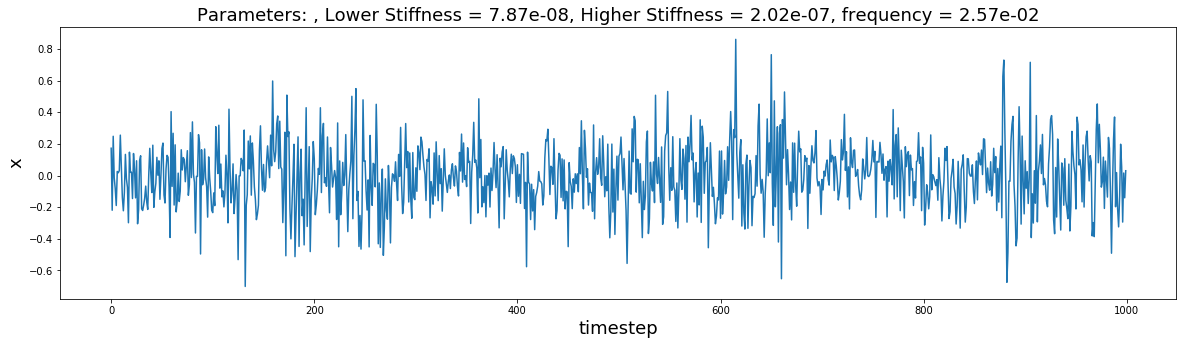

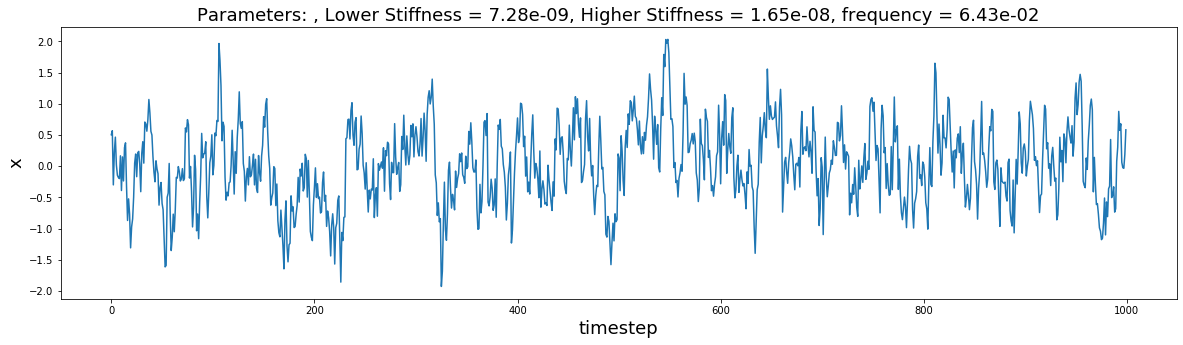

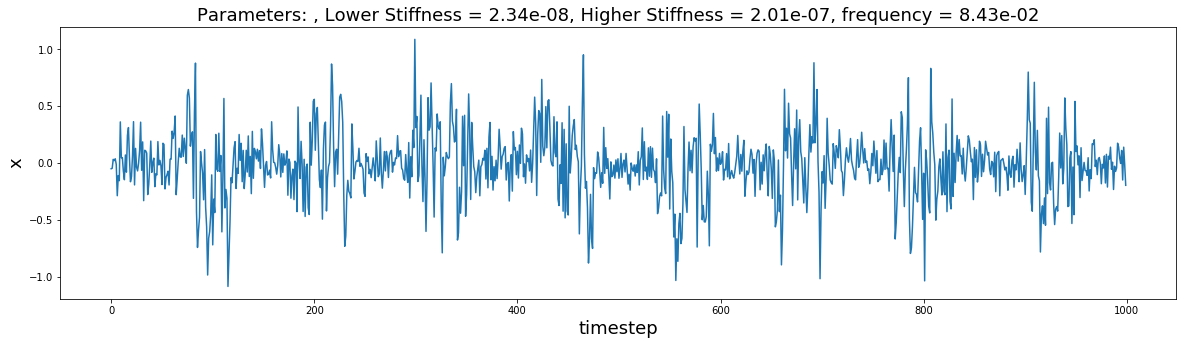

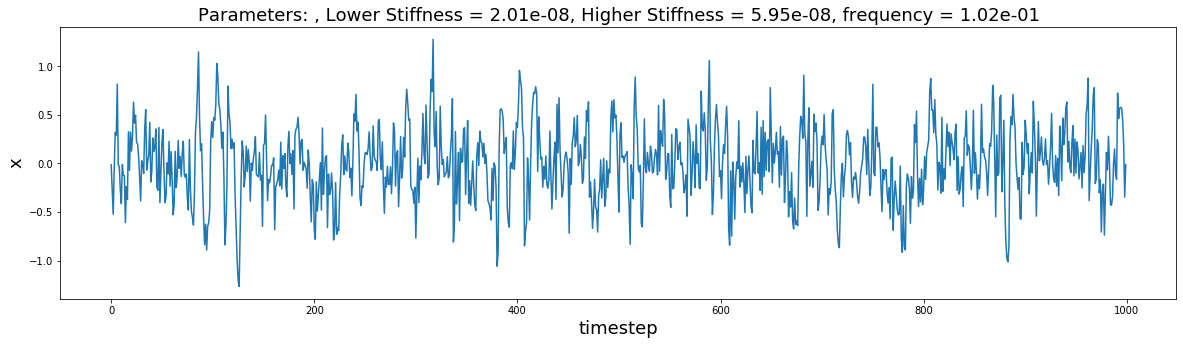

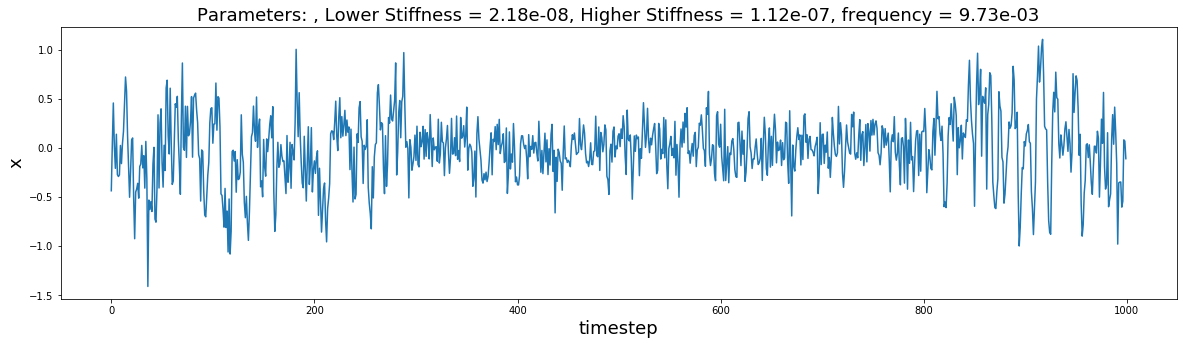

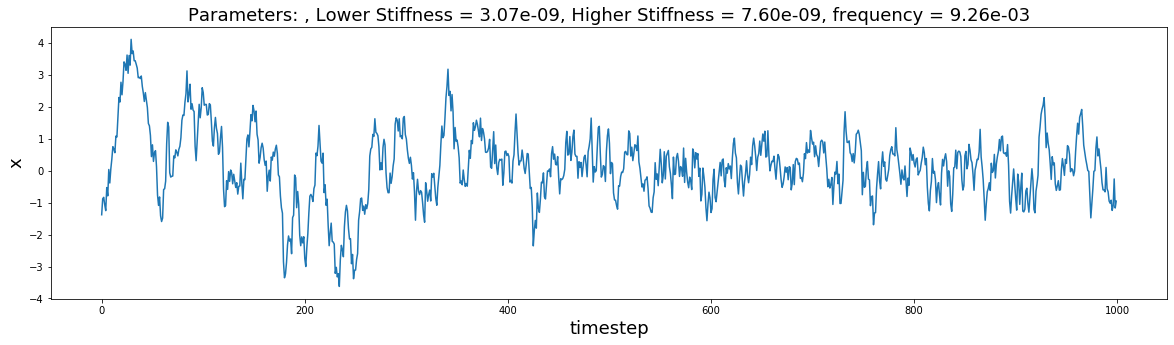

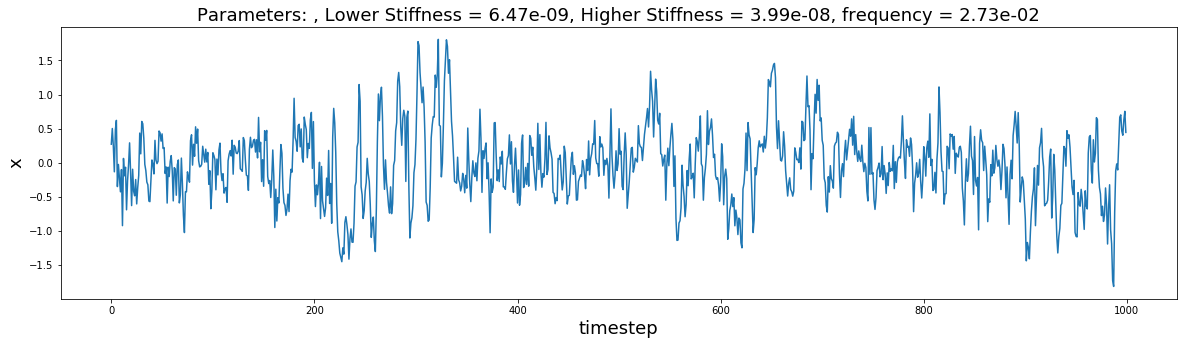

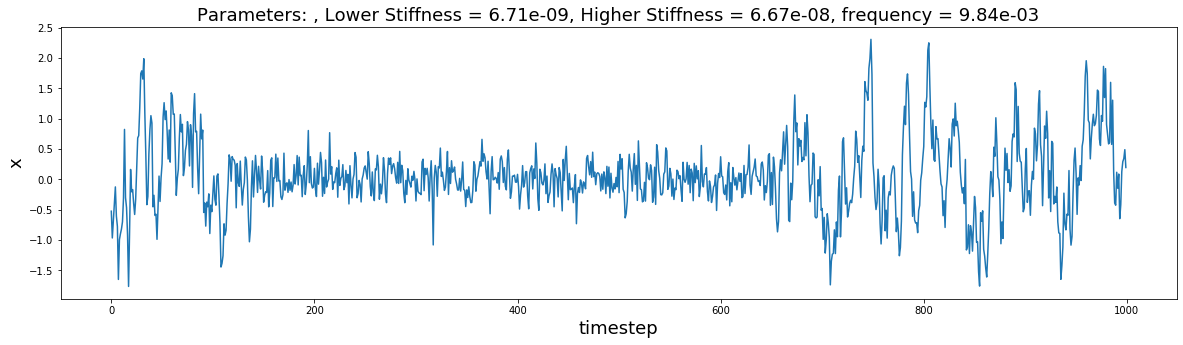

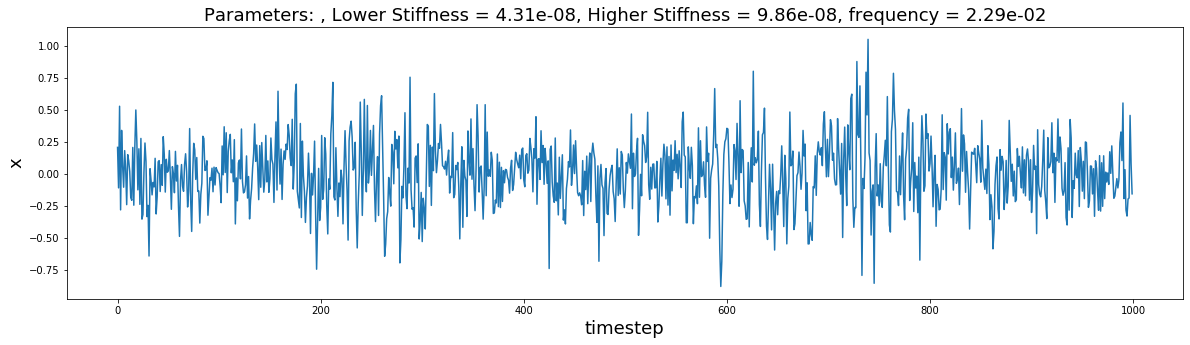

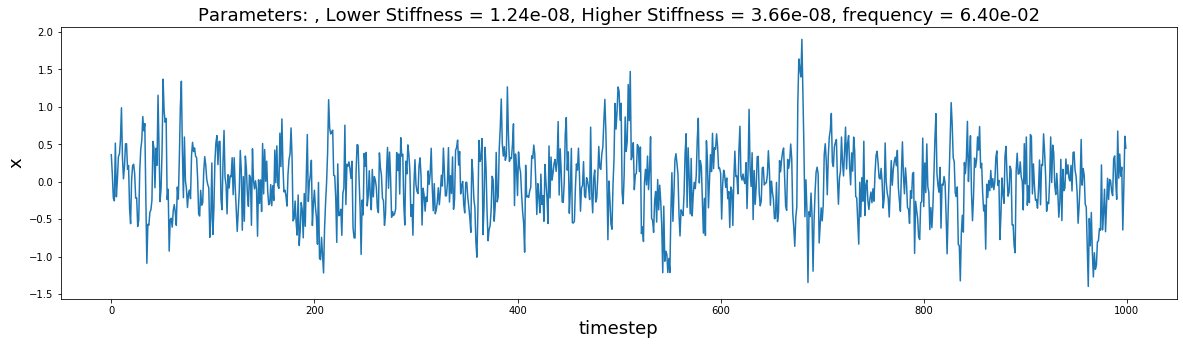

In [5]:
### Show some examples of simulated trajectories

number_of_trajectories_to_show = 10

%matplotlib inline
DeepCalib.plot_sample_trajectories(simulate_trajectory, number_of_trajectories_to_show)

## 4. CREATE AND COMPILE DEEP LEARNING NETWORK

The parameters of the deep learning network are defined and the network created. The summary of the network is printed where the output shape and number of parameters for each layer can be visualized.  

Comments:
1. The parameter <strong>input_shape</strong> determines the shape of the input sequence, given by the number of time-steps times the number of samples in each input sequence. Make sure your input shape dimensions match the length of the input trajectory, in this example 2 x 500 = 1000.
2. The parmameter <strong>conv_layers_dimensions</strong> determines the number and size of LSTM layers.
3. The parameter <strong>number_of_outputs</strong> determines the number of outputs, i.e. the number of force field parameters to be estimated.

In [12]:
### Define parameters of the deep learning network
input_shape = (2, 500)      
lstm_layers_dimensions = (1000, 250, 50)
number_of_outputs = 3

### Create deep learning network
network = DeepCalib.create_deep_learning_network(input_shape, lstm_layers_dimensions, number_of_outputs)

### Print deep learning network summary
network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2, 1000)           6004000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 2, 250)            1251000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                60200     
_________________________________________________________________
output (Dense)               (None, 3)                 153       
Total params: 7,315,353
Trainable params: 7,315,353
Non-trainable params: 0
_________________________________________________________________


## 5. TRAIN DEEP LEARNING NETWORK

The parameters for the training of the deep learning network are defined and the network is trained. The sample size, iteration number, MSE, MAE and the time of each iteration is printed.

Comments:
1. The parameter <strong>sample_sizes</strong> determines the sizes of the batches of trajectories used in the training.
2. The parameter <strong>iteration_numbers</strong> determines the numbers of batches used in the training.
3. The parameter <strong>verbose</strong> determines the frequency of the update messages. It can be either a boolean value (True/False) or a number between 0 and 1.

In [ ]:
### Define parameters of the training

sample_sizes = (8, 32, 128, 512, 2048)
iteration_numbers = (1001, 1001, 1001, 2001, 4001)
verbose = .1

### Training
training_history = DeepCalib.train_deep_learning_network(network, simulate_trajectory, sample_sizes, iteration_numbers, verbose)

Sample size      8   iteration number      1   MSE     0.2013   MAE     0.3831   Time 6001.618385 ms
Sample size      8   iteration number     11   MSE     0.2753   MAE     0.4711   Time 734.197378 ms
Sample size      8   iteration number     21   MSE     0.1878   MAE     0.3399   Time 734.199524 ms
Sample size      8   iteration number     31   MSE     0.1967   MAE     0.3529   Time 718.585014 ms
Sample size      8   iteration number     41   MSE     0.1374   MAE     0.3153   Time 734.202862 ms
Sample size      8   iteration number     51   MSE     0.1395   MAE     0.2992   Time 718.572617 ms
Sample size      8   iteration number     61   MSE     0.1402   MAE     0.3288   Time 718.572378 ms
Sample size      8   iteration number     71   MSE     0.1830   MAE     0.3400   Time 734.176159 ms
Sample size      8   iteration number     81   MSE     0.1042   MAE     0.2564   Time 734.166145 ms
Sample size      8   iteration number     91   MSE     0.0764   MAE     0.2140   Time 718.549728 ms

## 6. PLOT LEARNING PERFORMANCE

The learning performance is plotted. The MSE, MAE, sample size, iteration number and iteration time are plotted against the number of timesteps. 

Comment:
1. The parameter <strong>number_of_timesteps_for_average</strong> determines the length of the average. It must be a positive integer number.

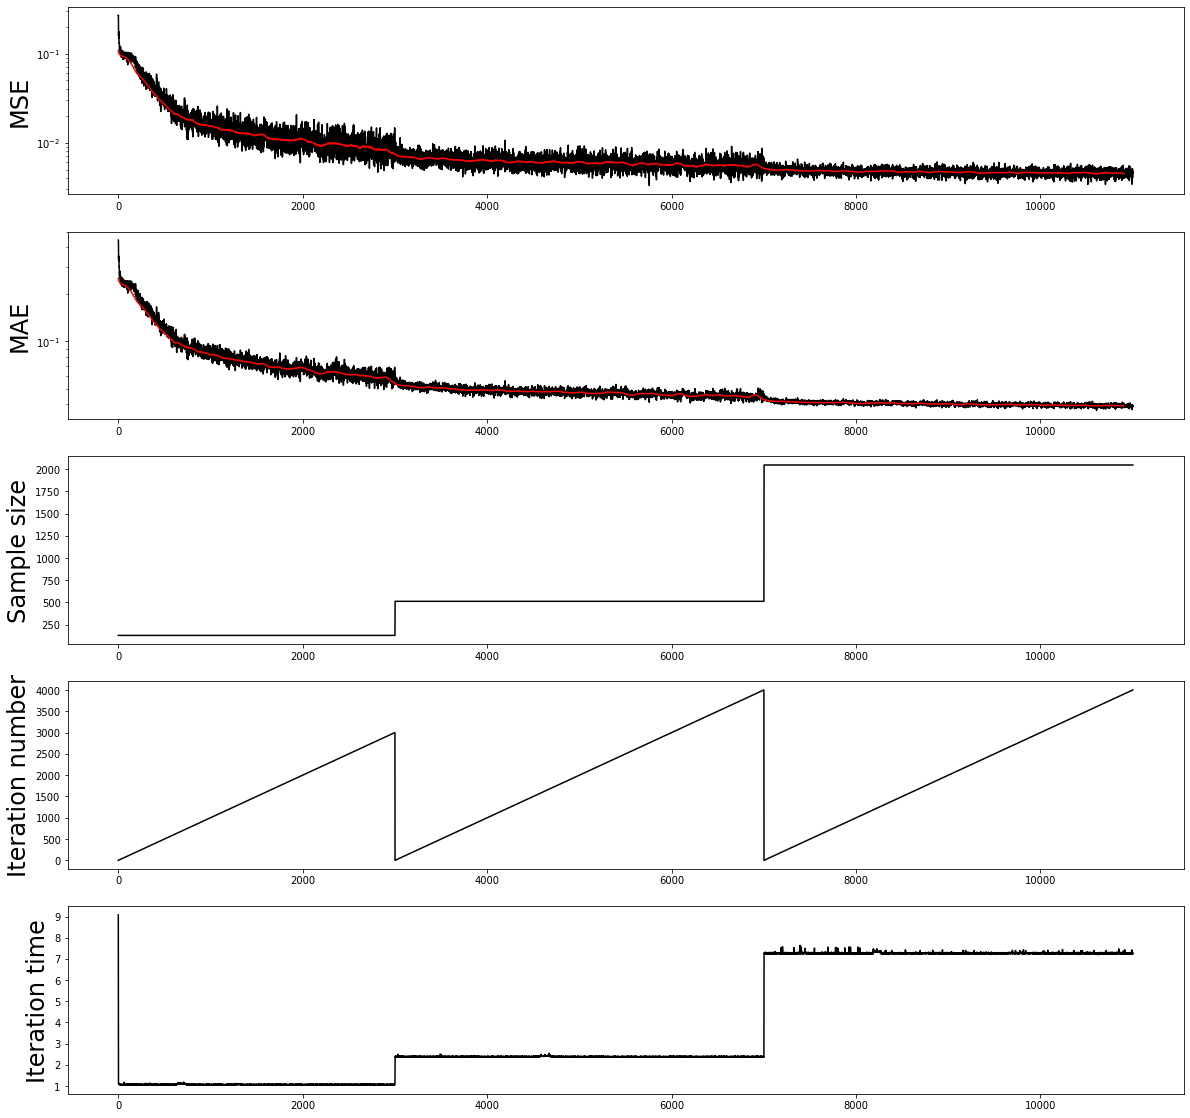

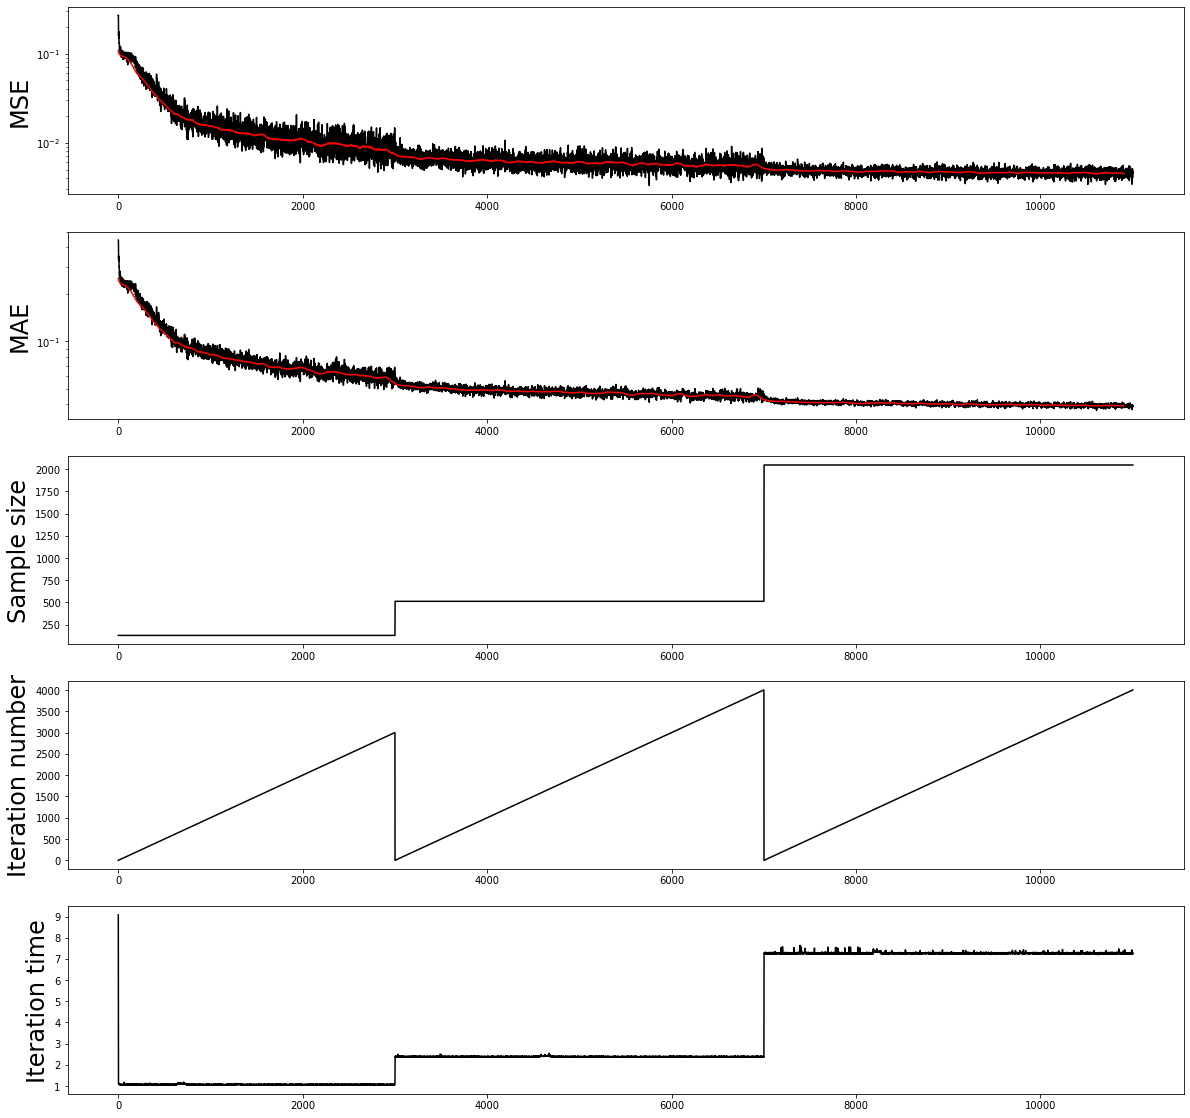

In [9]:
### Plot learning performance
number_of_timesteps_for_average = 100

DeepCalib.plot_learning_performance(training_history, number_of_timesteps_for_average)

## 7. TEST DEEP LEARNING NETWORK ON NEW SIMULATED TRAJECTORIES

The deep learning network is tested on new simulated trajectories (parameters are defined in [section 2](#sec2)). The predicted values of the targets are plotted as function of their ground-truth values both in scaled and physical units.

Comments:
1. The parameter <strong>number_of_predictions_to_show</strong> determines the number of predictions that are shown.

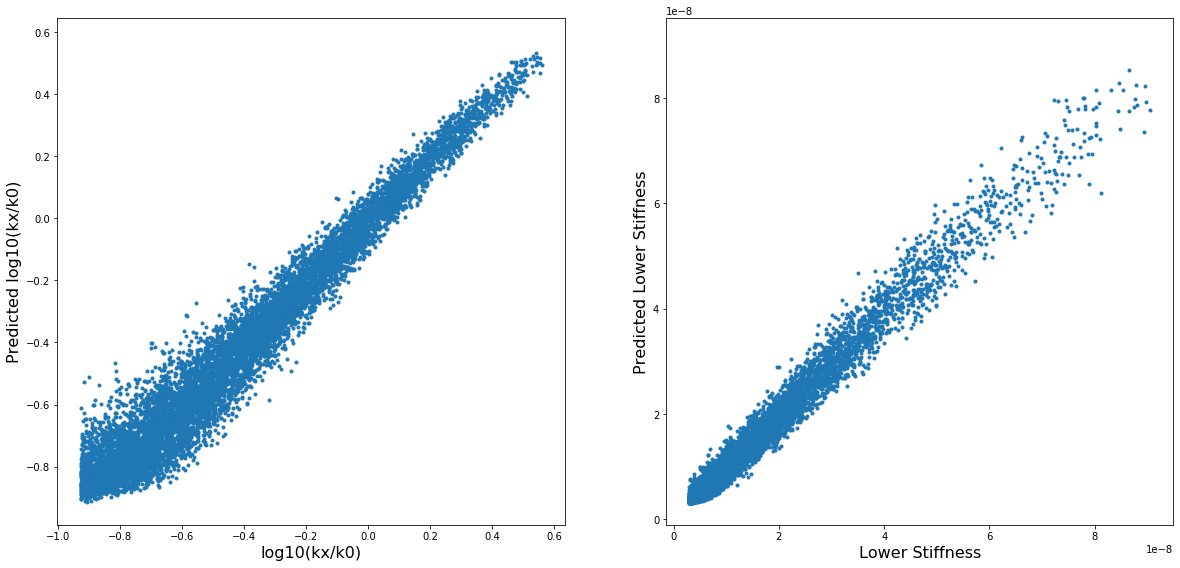

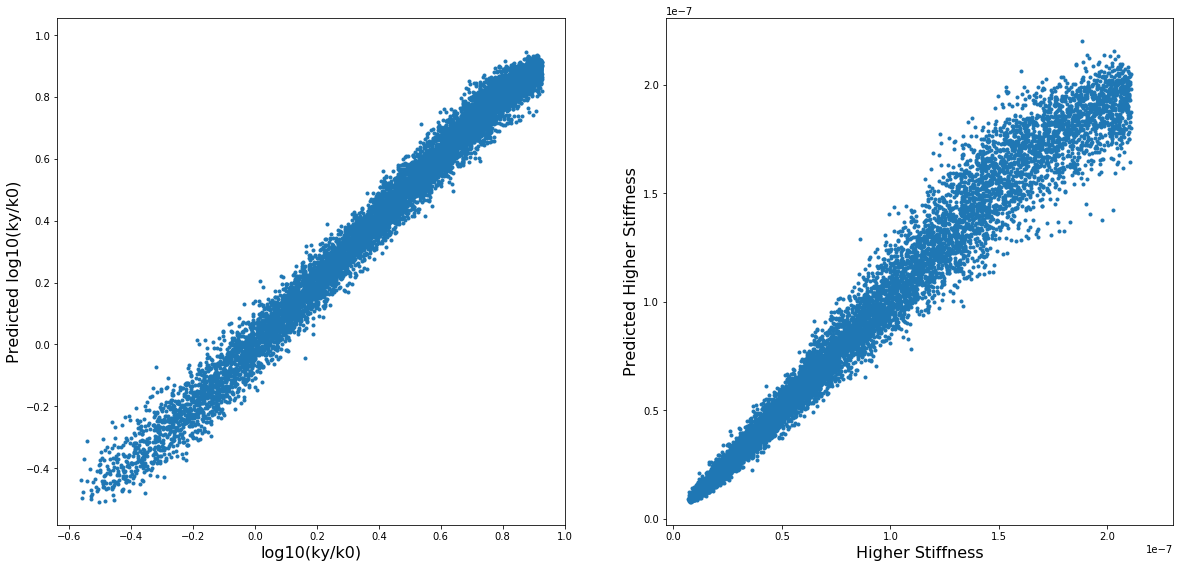

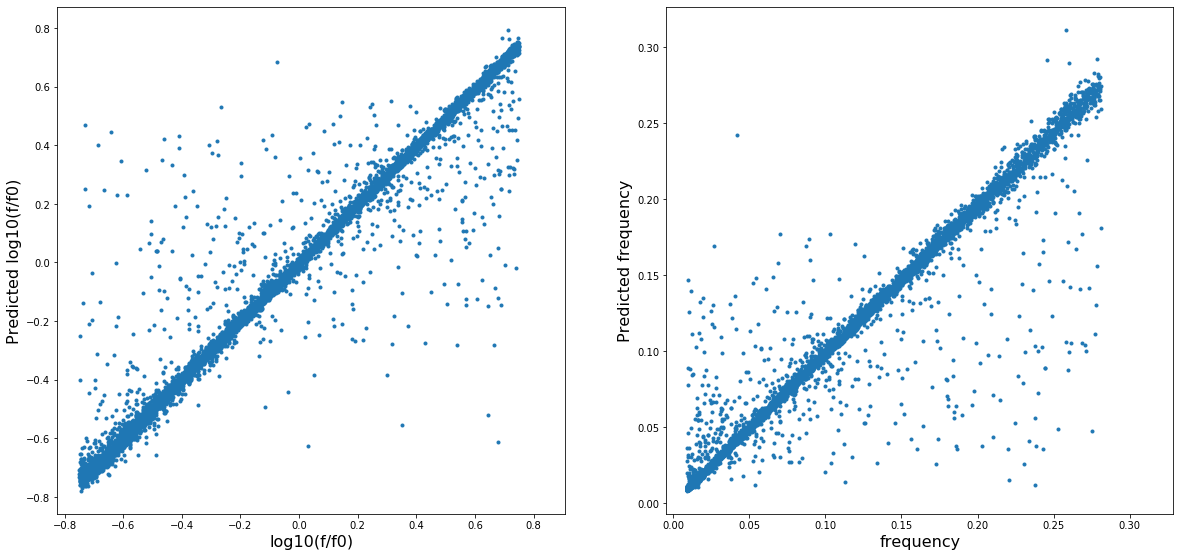

In [10]:
### Test the predictions of the deep learning network on some generated trajectories

number_of_predictions_to_show = 1000

%matplotlib inline
DeepCalib.plot_test_performance(simulate_trajectory, network, rescale_targets, number_of_predictions_to_show)

## 8. SAVE DEEP LEARNING NETWORK

Comments:
1. The parameter <strong>save_file_name</strong> is the name of the file where the deep learnign network is saved.
2. By default, the network is saved in the same folder where DeepCalib is running.

In [11]:
save_file_name = 'Network_Example_4a.h5'
network.save(save_file_name)